# Toxic Comment Classification

## Objective

Discussions on communities are difficult when there is a threat of harrasment, abuse. This will make the people to stop express themselves and to seek opininons from these platforms. These forums find difficulty to ease communications which is leading to remove the commenting feature from their communities

This projects aim to classify comments in the wikipedia talks page based on their toxicity levels like toxic, identity hate , severe toxic, obscene, threat and insult. Proper models will help online communities to deliver fruitful service to the users.

From the trained models, the most relevant model must be picked, a web service must be hosted, and the performance is discussed

## Dataset

Dataset is from wikipedias talk page. Since the data can belong to multiple label simultaneously this is a multi label classifier.
Kaggle link for the dataset [1] - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Importing Required Libraries

Import the required packages and libraries needed for this project

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import warnings
import wordcloud

warnings.filterwarnings('ignore')

from wordcloud import WordCloud 
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import classifiers metrices and plots
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix,f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


### Data Loading

In [4]:
# Read the data and display first 10 rows

data = pd.read_csv('data.csv')
data.head(10) # visualize first 10 data of the input

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


**We have data in the comment_text column as independent variable and other 6 columns from toxic to identity_hate as our dependent variables.
Rows that are having values 0 for all the 6 categories are non-toxic comments**

In [5]:
data.info() # gives the information about the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


* Dataset is clean with no null values so we dont want to do any cleaning methods.

There are six labels in out dataset and comments that are not present in any of these labels can be classified as non_toxic comments.

##### Display the number of comments in each label

In [6]:
rowsum=data.iloc[:,2:].sum(axis=1)
data['non_toxic']=(rowsum==0) # Check whether data is non_toxic and assign a boolean value in the non_toxic column 
data['non_toxic']=data['non_toxic'].astype(int) # Convert the boolean value in the non_toxic value to 0 or 1

In [7]:
# find number of comments in each category
data.iloc[:,2:].sum()

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
non_toxic        143346
dtype: int64

From analysing the above result we can see that there are a lot more data is present in non_toxic comment which wont be necessary for us to train the model. Inorder to reduce the processing time we can remove sum of the non_toxic comment from the datset.

### Data Visualisation & Analysis

For better understanding of the data we can plot the  dataset using various plots 

In [8]:
data_non_tox=data[data['non_toxic']==1] # dataset with non_toxic comments only

In [9]:
data_non_tox= data_non_tox.iloc[:50000,:] # Selecting only 50000 non_toxic comments

##### create a new data frame with only 50000 nontoxic data and all other data in the same amount

In [9]:
# Insert all non_toxic comments to the new data frame
data_new = data[data['non_toxic']==0]

In [10]:
# add 100000 non_toxic comments to the data frame
data_new = pd.concat([data_new,data_non_tox])
data_new = data_new.sample(frac=1) #Shuffle the data in the dataframe

From the above data we can see that index of the data has been changed because we removed non_toxic data from the orginal data. So we  will be resetting the index 

In [11]:
# reset index and display first few rows in the data frame
data_new.reset_index(drop=True, inplace=True)
data_new.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,21311b3a6a77534b,"""\n\nOK. A talk page... \n\n Rick Perry edit:...",0,0,0,0,0,0,1
1,a44bbf2df12780e2,"Fuck off commie, stop covering up the fact you...",1,0,1,0,1,0,0
2,fe803a825b7d3aff,REDIRECT Talk:International Orange Chorale of ...,0,0,0,0,0,0,1
3,72e698d9a3bace7a,"""Please remove the recently added sepia-toned ...",0,0,0,0,0,0,1
4,6d54a03174011da6,Well Christians worship a man that has been de...,0,0,0,0,0,0,1
5,251dac831af76174,"""\nWelcome!\n\nHello, , and welcome to Wikiped...",0,0,0,0,0,0,1
6,09f7e0b6ca4b4704,"""\n\nRemove the lists of stations, no one is l...",0,0,0,0,0,0,1
7,68b062c29109de40,Article duplicated\nThis Cricketers article al...,0,0,0,0,0,0,1
8,8a71d771ce0032d7,"""Below you examples of what happens when someo...",0,0,0,0,0,0,1
9,5235d72f9cdac55d,"BLOOD will be on your hands too, Jimbo! \n\nB...",1,0,0,0,0,0,0


In [12]:
# Assign the dependent variable column names to an array
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Preprocess Dataset

Input dataset will be undergoing some prerprocessing to get a perfect model with maximum performance.

Following steps will be done to make preprocess the dependent variable (comment_text)

 1. Replace newline, carriage return, tabs and digits with white spaces
 2. Convert all the comments to lower case
 3. Split the comments into words
 4. Apply stemming to each words and remove stop words from the sentence.
 5. After applying this words are joined and attached to the same data frame



In [13]:

# Remove unnecessary characters, stopwords and then apply stemming to each words in the comment_text column of the data

ls = LancasterStemmer()
for i in range(0, len(data_new)):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    comments= regex.sub(" ", data_new['comment_text'][i])# replacing digits carrige returns, tabs and newline with blank space
    comments = comments.lower()
    comments = comments.split()
    comments1 = [ls.stem(word) for word in comments if not word in stopwords.words('english')]
    data_new['comment_text'][i] = ' '.join(comments1)
   

In [15]:
data_new['comment_text']

0         expl edit mad usernam hardc metallic fan rever...
1         aww match background colo seem stuck thank tal...
2         hey man real try edit war guy const remov rele...
3         mak real suggest improv wond sect stat lat sub...
4                                 sir hero chant rememb pag
                                ...                        
159566    second tim ask view complet contradict cov rel...
159567                        asham horr thing put talk pag
159568    spitz um ther act artic prostitut ring crunch ...
159569        look lik act put speedy first vert delet look
159570    real think understand cam ide bad right away k...
Name: comment_text, Length: 159571, dtype: object

Before removing the extra non_toxic comments when we tried to stem the data the processing time taken was very big and that too ended up with recursion error, memory allocation error etc.

We can see that all the comments are converted to lower case and stemming has been applied to each words

## Modeling and Evaluation

Next step in our process is to train the vectors created for train and test data of both the dataset using a particular model and then Evaluate the result by using test data.

Steps include:

1. Initialize the model - Random Forest Classifier
2. Define a function to visualise the confusion matrix produced
3. Train the Random Forest Classifier model using our preprocessed datas 
4. Evaluate the model output using various parameters like Accuracy, F1 score , Confusion Matrix

### Manipulating Dataset to Overcome Class Imbalance Issue

We will balance the dataset by maintaining a ratio of atleat 20-80 percentage between true label and false label so that we will overcome the class imbalance issue.

Steps involved are:
* Split the dataset in to 6 categories 1 for each label
* Balance each of these data set by adding 0 and 1 in atleat 80:20 ratio
* Model the data and analyse the performance

### Dataset Creation

##### 1) Splitting entire dataset in to 6 set one for each label

In [16]:
# Creating different datasets for each category

toxic_data = data_new.loc[:,['id','comment_text','toxic']]

severe_toxic_data = data_new.loc[:,['id','comment_text','severe_toxic']]

obscene_data = data_new.loc[:,['id','comment_text','obscene']]

threat_data = data_new.loc[:,['id','comment_text','threat']]

insult_data = data_new.loc[:,['id','comment_text','insult']]

hate_data = data_new.loc[:,['id','comment_text','identity_hate']]

#### 2) Balancing 0 and 1 data of each data with atleast 20-80 ratio

### Toxic
For toxic data we have 15000+ data for 1 so we take 5000 data each for 0 and 1

In [17]:
# Take 5000 rows for 0 and 1 cases and print the shape
toxic_data_0 = toxic_data[toxic_data['toxic'] == 0].iloc[0:5000,:]
toxic_data_0.shape

toxic_data_1 = toxic_data[toxic_data['toxic'] == 1].iloc[0:5000,:]
toxic_data_1.shape

(5000, 3)

In [18]:
toxic_data_1.shape

(5000, 3)

In [19]:
# concatinate the two datasets to get the final dataset for toxic comments

toxic_data_final = pd.concat([toxic_data_0,toxic_data_1],axis=0)

toxic_data_final.reset_index(drop=True, inplace=True) # Reset index

toxic_data_final.shape

(10000, 3)

In [20]:
toxic_data_final

,id,comment_text,toxic
0,0000997932d777bf,expl edit mad usernam hardc metallic fan rever...,0
1,000103f0d9cfb60f,aww match background colo seem stuck thank tal...,0
2,000113f07ec002fd,hey man real try edit war guy const remov rele...,0
3,0001b41b1c6bb37e,mak real suggest improv wond sect stat lat sub...,0
4,0001d958c54c6e35,sir hero chant rememb pag,0
...,...,...,...
9995,88ee361576d2463a,know els say artic stay fix also edit com lik ...,1
9996,88f4ed433a57bae3,guess marvel direct stuff cop direct handbook ...,1
9997,88f9931bbf26aed8,afl maj dick head funny cre network miss infor...,1
9998,8904b29a973e5204,car think car ban ha rath quit funny mean up a...,1


### Severe Toxic
For severe toxic we have 1595 samples so we can do the same method

In [21]:
# Take 1595 rows for 0 and 1 cases and print the shape
severe_toxic_data_0 = severe_toxic_data[severe_toxic_data['severe_toxic'] == 0].iloc[0:1595,:]
severe_toxic_data_0.shape

severe_toxic_data_1 = severe_toxic_data[severe_toxic_data['severe_toxic'] == 1].iloc[0:1595,:]
severe_toxic_data_1.shape

(1595, 3)

In [22]:
# concatinate the two datasets to get the final dataset for severe toxic comments

severe_toxic_data_final = pd.concat([severe_toxic_data_0,severe_toxic_data_1],axis=0)

severe_toxic_data_final.reset_index(drop=True, inplace=True) # Reset index

severe_toxic_data_final.shape

(3190, 3)

### Obscene

For obscene we have 8449 data so we will ake 5000 each

In [23]:
# Take 5000 rows for 0 and 1 cases and print the shape
obscene_data_0 = obscene_data[obscene_data['obscene'] == 0].iloc[0:5000,:]
obscene_data_0.shape

obscene_data_1 = obscene_data[obscene_data['obscene'] == 1].iloc[0:5000,:]
obscene_data_1.shape

(5000, 3)

In [24]:
# concatinate the two datasets to get the final dataset for obscene comments

obscene_data_final = pd.concat([obscene_data_0,obscene_data_1],axis=0)

obscene_data_final.reset_index(drop=True, inplace=True) # Reset index

obscene_data_final.shape

(10000, 3)

### Threat

For threat we have only 478 data so we will take atmost 80 percentage of the clean data else the dataset will be very small

In [25]:
# Take 1912 rows for 0 and 478 for 1 cases and print the shape
threat_data_0 = threat_data[threat_data['threat'] == 0].iloc[0:1912,:]
threat_data_0.shape

threat_data_1 = threat_data[threat_data['threat'] == 1].iloc[0:478,:]
threat_data_1.shape

(478, 3)

In [26]:
# concatinate the two datasets to get the final dataset for threat comments

threat_data_final = pd.concat([threat_data_0,threat_data_1],axis=0)

threat_data_final.reset_index(drop=True, inplace=True) # Reset index

threat_data_final.shape

(2390, 3)

In [27]:
threat_data_final

,id,comment_text,threat
0,0000997932d777bf,expl edit mad usernam hardc metallic fan rever...,0
1,000103f0d9cfb60f,aww match background colo seem stuck thank tal...,0
2,000113f07ec002fd,hey man real try edit war guy const remov rele...,0
3,0001b41b1c6bb37e,mak real suggest improv wond sect stat lat sub...,0
4,0001d958c54c6e35,sir hero chant rememb pag,0
...,...,...,...
2385,e26b106943e02cbf,bitch fuck hor suck dick big ass hol gay faggo...,1
2386,f264b7fb9a4b4f53,stupid head dumb stupid die die die go suck but,1
2387,f4dca9e513e0366f,hey hey faggot dead yet watch mom get rap filt...,1
2388,f780e4f42aa5a344,dea musulm,1


### Insult

We have only 7877 insult comments so we will take 5000 each 

In [28]:
# Take 5000 rows for 0 and 1 cases and print the shape
insult_data_0 = insult_data[insult_data['insult'] == 0].iloc[0:5000,:]
insult_data_0.shape

insult_data_1 = insult_data[insult_data['insult'] == 1].iloc[0:5000,:]
insult_data_1.shape

(5000, 3)

In [29]:
# concatinate the two datasets to get the final dataset for insult comments

insult_data_final = pd.concat([insult_data_0,insult_data_1],axis=0)

insult_data_final.reset_index(drop=True, inplace=True) # Reset index

insult_data_final.shape

(10000, 3)

### Identity Hate

We have only 1405 comments for Identity Hate so we will do the same method as threat to make the class balanced

In [30]:
# Take 5620 rows for 0 and 1405 data for 1 and print the shape
hate_data_0 = hate_data[hate_data['identity_hate'] == 0].iloc[0:5620,:]
hate_data_0.shape

hate_data_1 = hate_data[hate_data['identity_hate'] == 1].iloc[0:1405,:]
hate_data_1.shape

(1405, 3)

In [31]:
# concatinate the two datasets to get the final dataset for insult comments

hate_data_final = pd.concat([hate_data_0,hate_data_1],axis=0)

hate_data_final.reset_index(drop=True, inplace=True) # Reset index

hate_data_final.shape

(7025, 3)

We can add all these dataframe to a list so that we can process them easiy

In [32]:
# Combining all dataframes to a list
data_final=[toxic_data_final,severe_toxic_data_final,obscene_data_final,threat_data_final,insult_data_final,hate_data_final]

#### So these data sets will be used for all our experiments from now on to get better output

### Modelling and Evaluation

A function is created to split the data, vectorise the data, model the data and analyse the performance of the model 

In [33]:
def plot_conf(cm,label):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 12},
                cmap="Blues",
                fmt='.2f',
                linewidths=1,
                linecolor='steelblue',
                xticklabels=("Non-toxic", label),
                yticklabels=("Non-toxic", label))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.title('Confusion Matrix for '+label,fontsize=20)
    plt.show()

In [34]:
# Function to train the model test the model and evaluate the model using confusion matrix

def model_scoring(model,X_train,X_test,test,train,label):
    model.fit(X_train,train[label])
    predictions = model.predict(X_test)
    conf_matrix = confusion_matrix(test[label],predictions)
    
    # Plot the confusion matrix for better understanding
    plot_conf(conf_matrix,label)
   
    #create a list for various scores of the prediction 
    scores = { 'Accuracy Score' : [accuracy_score(test[label],predictions)],'Recall Score':[recall_score(test[label],predictions)],
              'Precision Score' : [precision_score(test[label],predictions)],'F1 Score' : [f1_score(test[label],predictions)]}
    
    # create a data frame with different scoring as column names
    scoring_data = pd.DataFrame(scores, index=[label])
    return(scoring_data)
    

In [38]:
rf=RandomForestClassifier(n_estimators=200, random_state=42, criterion='entropy')

In [39]:
def split_vec(data,ngram,test_size,model,label):
    cvec = CountVectorizer(ngram_range=(ngram))
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42, shuffle=True)
    X_train = train_data['comment_text'] # independent variable of train data
    X_test = test_data['comment_text']  # independent variable of test data
    # Vectorize training comments
    X_train_vec= cvec.fit_transform(X_train)
    X_test_vec = cvec.transform(X_test)
    score_data=model_scoring(model,X_train_vec,X_test_vec,test_data,train_data,label)
    return(score_data)

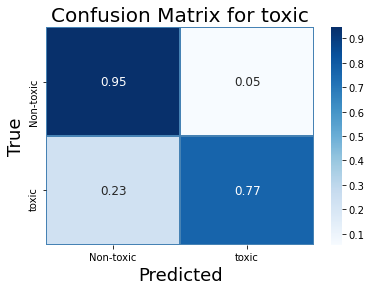

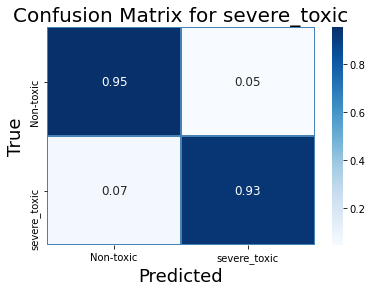

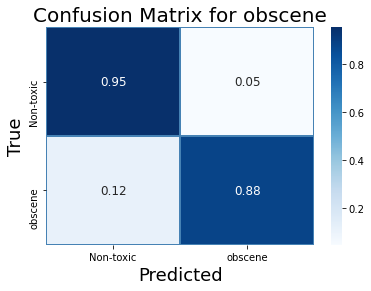

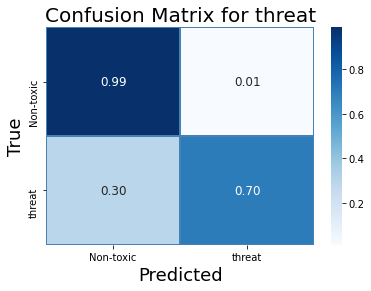

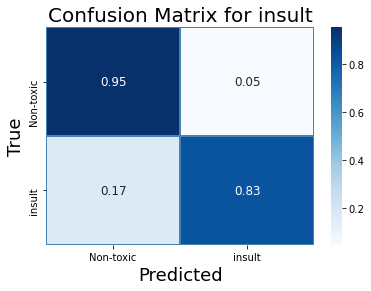

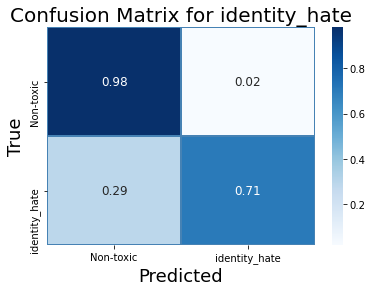

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.858667,0.767601,0.930406,0.841199
severe_toxic,0.944619,0.934874,0.952891,0.943796
obscene,0.919333,0.883800,0.947253,0.914427
threat,0.933054,0.702899,0.932692,0.801653
insult,0.891000,0.828435,0.940994,0.881134
identity_hate,0.925522,0.706856,0.900602,0.792053


In [40]:
data_scor_final_2= pd.DataFrame()
for data in data_final:
    data_scor_2=split_vec(data,(1,1),0.30,rf,data.columns.values[2])
    data_scor_final_2=pd.concat([data_scor_final_2,data_scor_2])
    
display(data_scor_final_2)

### Choosing the relevant model

Different models listed below were tried with different experimental setups:
- Logistic Regression
- Random Forest
- XGBoost
- Linear SVC
- Naive Bayes
- LSTM
- SVM
- NN, CNN, RNN
 Also Pre-trained Models and word embedding transfer learning using glove was experimented.

Despite the fact that numerous models and experimental settings outperformed the random forest classifier in terms of accuracy, we opted to adopt the random forest model for the final implementation after evaluating the benefits and drawbacks. This included improvisations such as dealing with data set imbalance, data cleaning, and preprocessing.

Because the random forest classifier is based on an ensemble model, it performed well in tests and was more flexible (low bias) and less susceptible to data (low variance).

### Web service build using pickling technique

## Pickling

The state of the art techniques required high computing power which lead to problems like limitation of hardware. Also predicting of large comments caused issues while generating the huge matrixes.
We are using a method of pickling inorder to recreate the ojects that we created after training the model and to save our model.This can be used by the application created for user.

In [41]:
import pickle

In [42]:
def model_pickling(data, label):
    
    X = data.comment_text
    y = data[label]

    # Initiate a Tfidf vectorizer
    tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    x_vec = tfidf.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format('Pickled_Files/GRP_22_'+label + '_vect'), "wb") as filename:   
        pickle.dump(tfidf, filename)   
        
    randomforest = RandomForestClassifier(n_estimators=200, random_state=42)
    randomforest.fit(x_vec, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format('Pickled_Files/GRP_22_'+label + '_model'), "wb") as filename:  
        pickle.dump(randomforest, filename)

In [ ]:
# Loop to create picklefiles in single run
for i,j in zip(data_final,labels):
    model_pickling(i, j)

## Testing functionality performed

A Flask app is set up to take data from the application and feed it to the model, which compares it to previously produced pickle files and displays the predicted values on the app's screen.The user can interact with a harmful comment classifier application that has been trained using the random forest classifier model. The user types in the remark, and the programme calculates the proportion of profanity in the comment after it is submitted.The input comment is stored in the csv whenever it is supplied. It can be used to improve the model's efficiency by further training it.

## Performance of the Classifier

**The model's predictions were rather accurate. It was able to reply to the negative remarks and classify them into various classifications with reasonable accuracy.
Sometimes the model didn't always react well to statements that weren't addressed and had multiple meanings in sentence contexts.**

Here are some of the examples:

**Example 1:**
There's no need to apologize. A Wikipedia article is made for reconciling knowledge about a subject from different sources,   and you've done history studies and not archaeology studies, I guess. I could scan the page, e-mail it to you, and then you could ask someone to translate the page.

**Prediction :**
Toxic:0.21, Sever Toxic : 0.18,  Obscene : 0.1, Insult : 0.09, Threat : 0 , Identity Hate : 0.03

**Example 2:**
THIS IS MY PAGE FUCKERS SO I CAN SAY WHAT I WANT. FUCK YOU DRINI AND NACONKANTARI... I HOPE YOU ENJOY YOUR SCHEDULED RAPING. 

**Predicion:**
Toxic:0.92, Sever Toxic : 0.79,  Obscene : 0.91, Insult : 0.86, Threat : 0.33 , Identity Hate : 0.41

## CI/CD pipeline

The CI/CD stands for Continuous Integration and Continuous Delivery.In Continuous Integration small changes are implemented i and the code in check in to repositories frequently.This is useful in integrating the code developed in different platforms.In Continuous Delivery the delievry is automated to selected infrastructure environments.So this ensures the way to push the code is automated.

Here we are simple pipeline so that in the future, a new individual might alter the model or feature vectorization settings simply by altering the pipeline function's arguments. If necessary, this must be done manually.

In [7]:
from sklearn.pipeline import Pipeline
from joblib import dump

In [6]:
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords.words('english'))),
                            ('model', RandomForestClassifier(n_estimators=200, random_state=42, criterion='entropy'))])

In [8]:
def create_pipeline(data, label,pipeline):
    
    X = data.comment_text
    y = data[label]
    filename=r"{}.joblib".format('Pipeline_Files/GRP_22_'+label + '_pipeline')
    dump(pipeline, filename=filename)

In [ ]:
for i,j in zip(data_final,labels):
    create_pipeline(i, j,pipeline)

## Conclusion

We used Random Forest to train the model and create pickle files, and then did the prediction using these pre-trained files.A comment is predicted with its toxicity level for each of the six labels to the user.

**Conclusion and future improvements to this project**

•	Improve the training dataset, by using data saved from user inputs, including more features with higher n-gram models

•	Improve the prediction scores across the 6 categories, including 'toxic', 'severe toxic, 'obscene', 'threat', 'insult', and 'identity hate'.

•	Improve the prediction ability, in which the model can recognize the word context (sentiment analysis) so that it can evaluate the toxic content probability of sentences, not only by specific words
